In [1]:
import os
import time

import dill
import matplotlib.pyplot as plt
import pyro
import seaborn as sns
import torch

pyro.settings.set(module_local_params=True)

from collab.foraging.locust import (conditioned_locust,
                                    get_locust_posterior_samples)
from collab.foraging.toolkit import plot_ds_trajectories, run_svi_inference

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

import matplotlib.pyplot as plt
import seaborn as sns
import torch

from collab.utils import find_repo_root, progress_saver

In [2]:
smoke_test = "CI" in os.environ
subset_starts = 1  # 420
subset_ends = 30 if smoke_test else 900
desired_frames = 50 if smoke_test else 250
num_iterations = 50 if smoke_test else 2000
num_samples = 20 if smoke_test else 500
num_steps = 10 if smoke_test else 100
sample_size = 100 if smoke_test else 1000
locust_sample_size = 100 if smoke_test else 178770
root = find_repo_root()


notebook_starts = time.time()

torch.Size([50]) torch.Size([50])


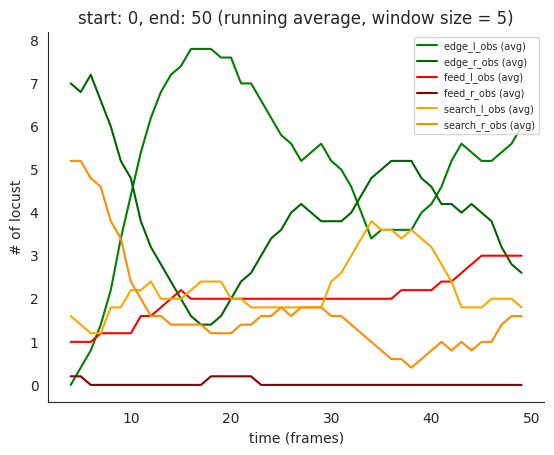

In [3]:
locust_count_data_path = os.path.join(
    root, "data/foraging/locust/ds/locust_counts15EQ20191202.pkl"
)

with open(locust_count_data_path, "rb") as f:
    locust_count_data = dill.load(f)

count_data = locust_count_data["count_data"]

start, end = 0, 50
start_time = torch.tensor(start).float()
end_time = torch.tensor(end).float()
step_size = 1
logging_times = torch.arange(start_time, end_time, step_size)

count_subset = {key: count_data[key][start:end] for key in count_data.keys()}

print(count_subset["edge_l_obs"].shape, logging_times.shape)

plot_ds_trajectories(
    count_subset,
    logging_times,
    title=f"start: {start}, end: {end}",
    window_size=5,
    observed=True,
)

init_state = {key[:-4]: count_subset[key][0] for key in count_subset.keys()}

In [4]:
def get_guide_locust():
    real_locust_guide = run_svi_inference(
        conditioned_locust,
        num_steps=num_steps,
        obs_times=logging_times,
        data=count_subset,
        init_state=init_state,
        start_time=start_time,
    )
    return real_locust_guide


sliced_locust_guide = progress_saver(
    name="sliced_locust_guide",
    subfolder="foraging/locust/ds/time_slices",
    properties=[num_steps, start, end],
    property_names=["num_steps", "start", "end"],
    code_f=get_guide_locust,
)

/home/rafal/s78projects/collaborative-intelligence/data/foraging/locust/ds/time_slices/sliced_locust_guide_num_steps_100_start_0_end_50.pkl
path found, loading data


In [9]:
def get_samples_locust():
    locust_samples = get_locust_posterior_samples(
        sliced_locust_guide,
        num_samples=num_samples,
        init_state=init_state,
        start_time=start,
        logging_times=logging_times,
    )
    return locust_samples


sliced_posterior_samples = progress_saver(
    name="sliced_posterior_samples",
    subfolder="foraging/locust/ds/time_slices",
    properties=[num_steps, start, end],
    property_names=["num_steps", "start", "end"],
    code_f=get_samples_locust,
)

/home/rafal/s78projects/collaborative-intelligence/data/foraging/locust/ds/time_slices/sliced_posterior_samples_num_steps_100_start_0_end_50.pkl
path missing, executing code
Error executing code: 'AutoMultivariateNormal' object has no attribute 'items'


In [ ]:
state = "edge_r"
color = "green"

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

locust_plot(
    logging_times,
    locust_prior_samples[state],
    locust_true_traj[state],
    f"# in {state}",
    color,
    "ground truth",
    ax,
    legend=True,
    test_plot=False,
    mean_label="prior mean",
)